In [11]:
import Pkg

import CairoMakie

using IntervalSets
using MMJMesh.Gmsh
using MMJMesh.Plots
using MMJMesh.Meshes
using MMJMesh.Utilities
using MMJMesh.Mathematics
using LinearAlgebra
using Symbolics
using DomainSets
using CairoMakie
using SparseArrays

using GLMakie
using WGLMakie
WGLMakie.activate!()

Pkg.add(url="https://github.com/matthiasbaitsch/mmjmesh.git")

    Updating git-repo `https://github.com/matthiasbaitsch/mmjmesh.git`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [12]:
include("fem.jl")

applyDirichletBCs! (generic function with 1 method)

### Netzgenerierung für rechteckige Platte

#### quadratische FEM-Elemente (Beispiel hier: 8 x 8 m^2 Platte)


In [22]:
p = (
    E = 31000e6,
    h = 0.2,
    ν = 0,
    q = 5e3);

ma = zeros(40)

for l = 1:40
    m = makemeshonrectangle(8.0, 8.0, 2*l, 2*l)

    m.data[:kefunc] = plateKe(p)
    m.data[:refunc] = plateRe(p.q)

    K,r = assembleKr(m,3)
    for rN ∈ m.groups[:boundarynodes]
        nodeD = nodeDOFs(rN,3)
        applyDirichletBCs!(nodeD, K, r)
    end
    # sparse = dünnbesetzte Matrix = Matrix mit vielen Nullen 
    # sparse() speichert die Nullen der Matrix nicht, daher ist es schneller zu berechnen

    KSparse = sparse(K)
    u = KSparse\r
    w = zeros(trunc(Int,(size(u,1)/3)))
    for i = 1:(trunc(Int,(size(u,1)/3)))
        w[i] = u[i*3-2]
    end
    ma[l] = maximum(w) 
end

#### Plotten der Verformung bei unterschiedlicher Anzahl von Elementen

In [ ]:
function plotsol(n)
    m, wHat = plate(params, n);
    plotw(
        m, wHat, 
        w=1200, h=650,
        zs=2400*maximum(wHat), # plotw scales by 1 / maximum(wHat)
        edgesvisible=true, edgelinewidth=4,
        limits=(nothing,nothing,(0,1.15))
    )
end

In [23]:
# Freiheitsgrade
dofs = zeros(40)
for l = 1:40 
    m = makemeshonrectangle(8.0, 8.0, 2*l, 2*l)
    bN = m.groups[:boundarynodes]
    dofs[l] = nnodes(m) * 3 -  size(bN,1) * 3
end

#### Konvergenzplot 8 x 8 Platte

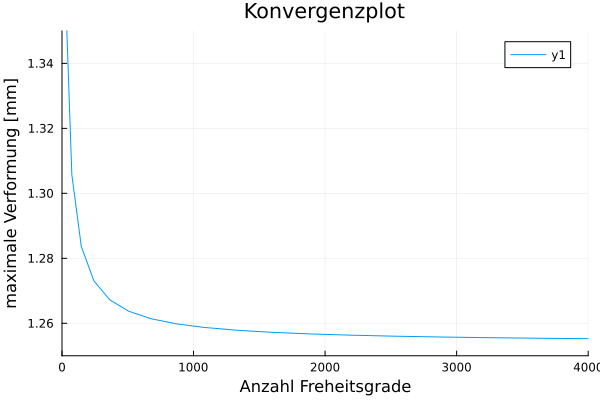

In [26]:
using Plots
Plots.plot(dofs, ma*1000)
Plots.plot!(title = "Konvergenzplot", xlabel = "Anzahl Freheitsgrade", ylabel = "maximale Verformung [mm]")
Plots.plot!(xlims = (0, 4000), ylims = (1.25, 1.35), xticks = 0:1000:4000, yticks = 1.26:0.02:1.34)

In [27]:
w_czerny = 5e3 * 8^4 / (31000e6 * 0.2^3) * 0.0152
100 * abs(ma[18] - w_czerny) / w_czerny

0.012590140397387267

### Schnittgrößen
